In [1]:
import numpy as np
import IPython
from IPython.display import Audio, display
import librosa, librosa.display
import soundfile as sf

import sys, random  
sys.path.insert(0, '../')
from audioldm2 import text_to_audio, build_model, seed_everything
from interfaces.diffusion_helper_qkv import *

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [3]:
import warnings

def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()


In [4]:
def get_model(model_name):
    print('Loading model')
    
    latent_diffusion = build_model(model_name=model_name)
    latent_diffusion.latent_t_size = int(duration * latent_t_per_second)

    print('Model loaded')
    return latent_diffusion


In [5]:
model_name = 'audioldm_16k_crossattn_t5'
latent_t_per_second=25.6
sample_rate=16000
duration = 10.0 #Duration is minimum 10 secs. The generated sounds are weird for <10secs
guidance_scale = 3
random_seed = 42
n_candidates = 1
batch_size = 1
ddim_steps = 20


import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"


latent_diffusion = get_model(model_name)

Loading model
Loading AudioLDM-2: audioldm_16k_crossattn_t5
Loading model on cuda:0
{'variables': {'sampling_rate': 16000, 'mel_bins': 64, 'latent_embed_dim': 8, 'latent_t_size': 256, 'latent_f_size': 16, 'in_channels': 8, 'optimize_ddpm_parameter': True, 'warmup_steps': 5000}, 'step': {'validation_every_n_epochs': 1, 'save_checkpoint_every_n_steps': 5000, 'max_steps': 1500000, 'save_top_k': 2}, 'preprocessing': {'audio': {'sampling_rate': 16000, 'max_wav_value': 32768, 'duration': 10.24}, 'stft': {'filter_length': 1024, 'hop_length': 160, 'win_length': 1024}, 'mel': {'n_mel_channels': 64, 'mel_fmin': 0, 'mel_fmax': 8000}}, 'augmentation': {'mixup': 0}, 'model': {'target': 'audioldm2.latent_diffusion.models.ddpm.LatentDiffusion', 'params': {'first_stage_config': {'base_learning_rate': 8e-06, 'target': 'audioldm2.latent_encoder.autoencoder.AutoencoderKL', 'params': {'sampling_rate': 16000, 'batchsize': 4, 'monitor': 'val/rec_loss', 'image_key': 'fbank', 'subband': 1, 'embed_dim': 8, 'ti

/home/purnima/anaconda3/envs/audioldm2/lib/python3.8/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/home/purnima/anaconda3/envs/audioldm2/lib/python3.8/site-packages/torchaudio/transforms/_transforms.py:580: UserWarning: Argument 'onesided' has been deprecated and has no influence on the behavior of this module.
  warnings.warn(


DiffusionWrapper has 265.53 M params.


/home/purnima/anaconda3/envs/audioldm2/lib/python3.8/site-packages/torch/nn/utils/weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


Model loaded


In [7]:
def get_word_pairs():
    adjective_noun_pairs = []
    verb_noun_pairs = []

    with open('AudioPairBank/adjective_noun_pairs.txt') as f:
        adjective_noun_pairs_str = f.read()

    with open('AudioPairBank/verb_noun_pairs.txt') as f:
        verb_noun_pairs_str = f.read()

    adjective_noun_pairs = adjective_noun_pairs_str.split("\n")
    verb_noun_pairs = verb_noun_pairs_str.split("\n")

    return np.array(adjective_noun_pairs), np.array(verb_noun_pairs)

adjective_noun_pairs, verb_noun_pairs = get_word_pairs()

In [11]:
ind_choices = np.random.choice(range(len(adjective_noun_pairs)), 5)
print("Some Adjective Noun Pairs for inspiration ==>", adjective_noun_pairs[ind_choices])

ind_choices = np.random.choice(range(len(verb_noun_pairs)), 5)
print("Some Verb Noun Pairs for inspiration ==>", verb_noun_pairs[ind_choices])

Some Adjective Noun Pairs ==> ['natural noise' 'funny woman' 'happy sound' 'scary music' 'sharp tension']
Some Verb Noun Pairs ==> ['growling guitar' 'opening announcement' 'exploding bomb' 'flying bird'
 'talking man']


In [20]:
def plot_all(wavs, titles):
    %matplotlib inline

    num_cols = 5
    
    nrows = len(wavs)//num_cols 
    if len(wavs)%num_cols > 0:
        nrows += 1
    print('num rows=', nrows)
    fig, axs = plt.subplots(nrows=nrows, ncols=num_cols, figsize=(15,3))
    for i, wav in enumerate(wavs):
        nrow = i//num_cols
        ncol = i%num_cols
        IPython.display.display(IPython.display.Audio(wav, rate=16000))

        D = librosa.amplitude_to_db(np.abs(librosa.stft(wav, hop_length=512)),ref=np.max)
        if nrows>1:
            librosa.display.specshow(D, y_axis='linear', sr=16000, hop_length=512, x_axis='time', ax=axs[nrow][ncol])
            axs[nrow][ncol].set_title(titles[i])
        else:
            librosa.display.specshow(D, y_axis='linear', sr=16000, hop_length=512, x_axis='time', ax=axs[ncol])
            axs[ncol].set_title(titles[i])

num rows= 1


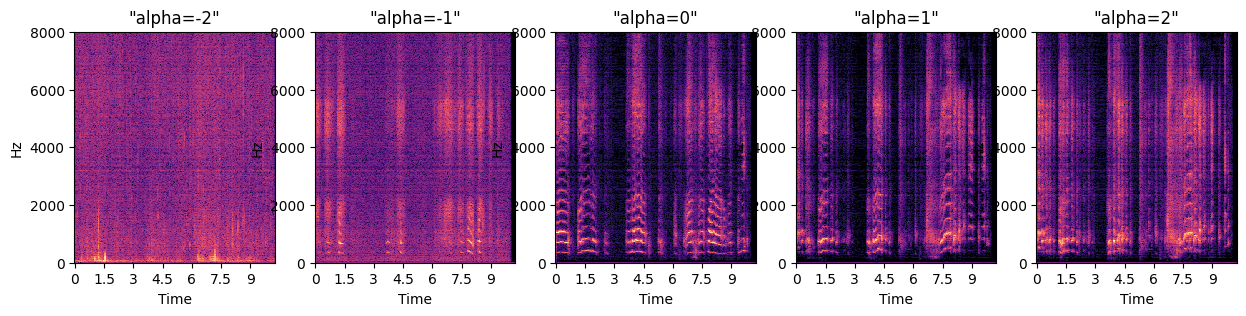

In [21]:
text = "A laughing baby" #prompt
describing_word = "laughing" #word within the prompt that should be emphasized

random_seed = 42

wavs = []
titles = []
for ind, i in enumerate(np.arange(-2,3,1)):
    predicted_wav, _ = sample_diffusion_attention_core(source_text=None, target_text=text, random_seed=random_seed, ddim_steps=20,\
                                                   latent_diffusion=latent_diffusion,
                                                   target_selected_word_list=[describing_word], target_value_list=[i],
                                                   disable_tqdmoutput = True
                                                   )
    wavs.append(predicted_wav)
    titles.append('"alpha='+str(i) + '"')
    
plot_all(wavs, titles)